In [1]:
%matplotlib nbagg
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import galsim

In [2]:
# Read in the wavelength bin boundaries
with open('/home/jchiang/work/DESC/imSim/tests/data/sky_cat_multiproc_test.yaml') as fobj:
    config = yaml.safe_load(fobj)
bins = config['SED_models']['tophat']['bins']
wl0 = [_[0] for _ in bins]
wl0.append(bins[-1][0] + bins[-1][1])
wl0 = 0.1*np.array(wl0)  # convert to nm

In [3]:
# Read in an example set of tophat SED values.
df = pd.read_parquet('/home/jchiang/work/DESC/imSim/tests/data/galaxy_9683_det94_det95_single_objs.parquet')
Lnu0 = df.iloc[1].sed_val_bulge

<IPython.core.display.Javascript object>


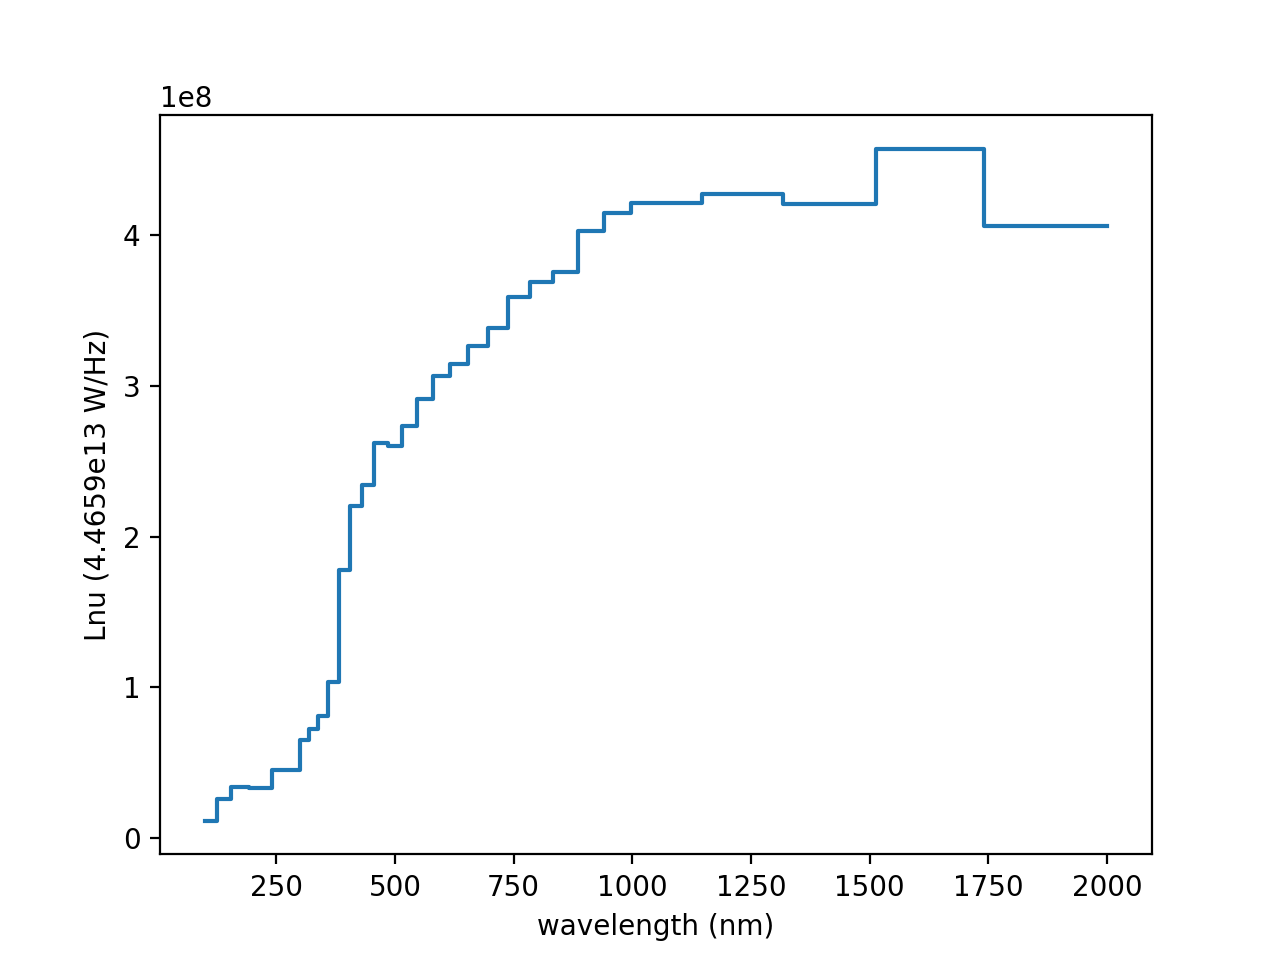

In [4]:
# Set up arrays for plotting the tophats and make the plot.
wl, Lnu = [], []
for i in range(len(Lnu0)):
    wl.append(wl0[i])
    wl.append(wl0[i+1])
    Lnu.append(Lnu0[i])
    Lnu.append(Lnu0[i])
plt.figure()
plt.plot(wl, Lnu)
plt.xlabel('wavelength (nm)')
plt.ylabel('Lnu (4.4659e13 W/Hz)');

<IPython.core.display.Javascript object>


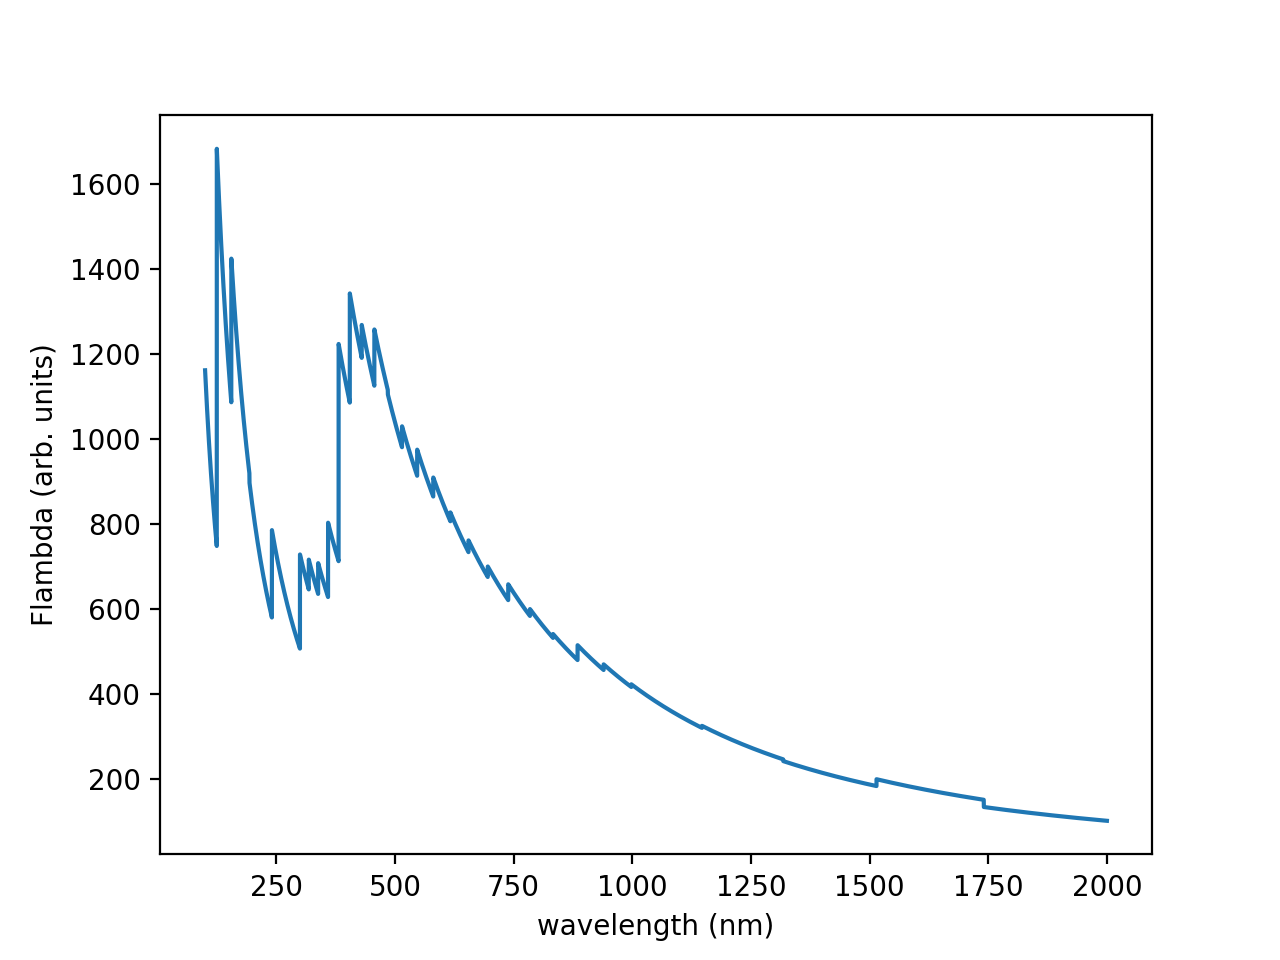

In [5]:
# Convert y-axis to Flambda (with normalization later set a 500nm rest frame.)
#
# The current procedure resamples to finer bins then divides Lnu by wl**2 to convert to Flambda:
wl_resamp = np.arange(min(wl), max(wl), 0.1)
Lnu_resamp = np.interp(wl_resamp, wl, Lnu)
Flambda = Lnu_resamp/wl_resamp**2  # Scale is arbitrary at this point.
plt.figure()
plt.plot(wl_resamp, Flambda)
plt.xlabel('wavelength (nm)')
plt.ylabel('Flambda (arb. units)');

<IPython.core.display.Javascript object>


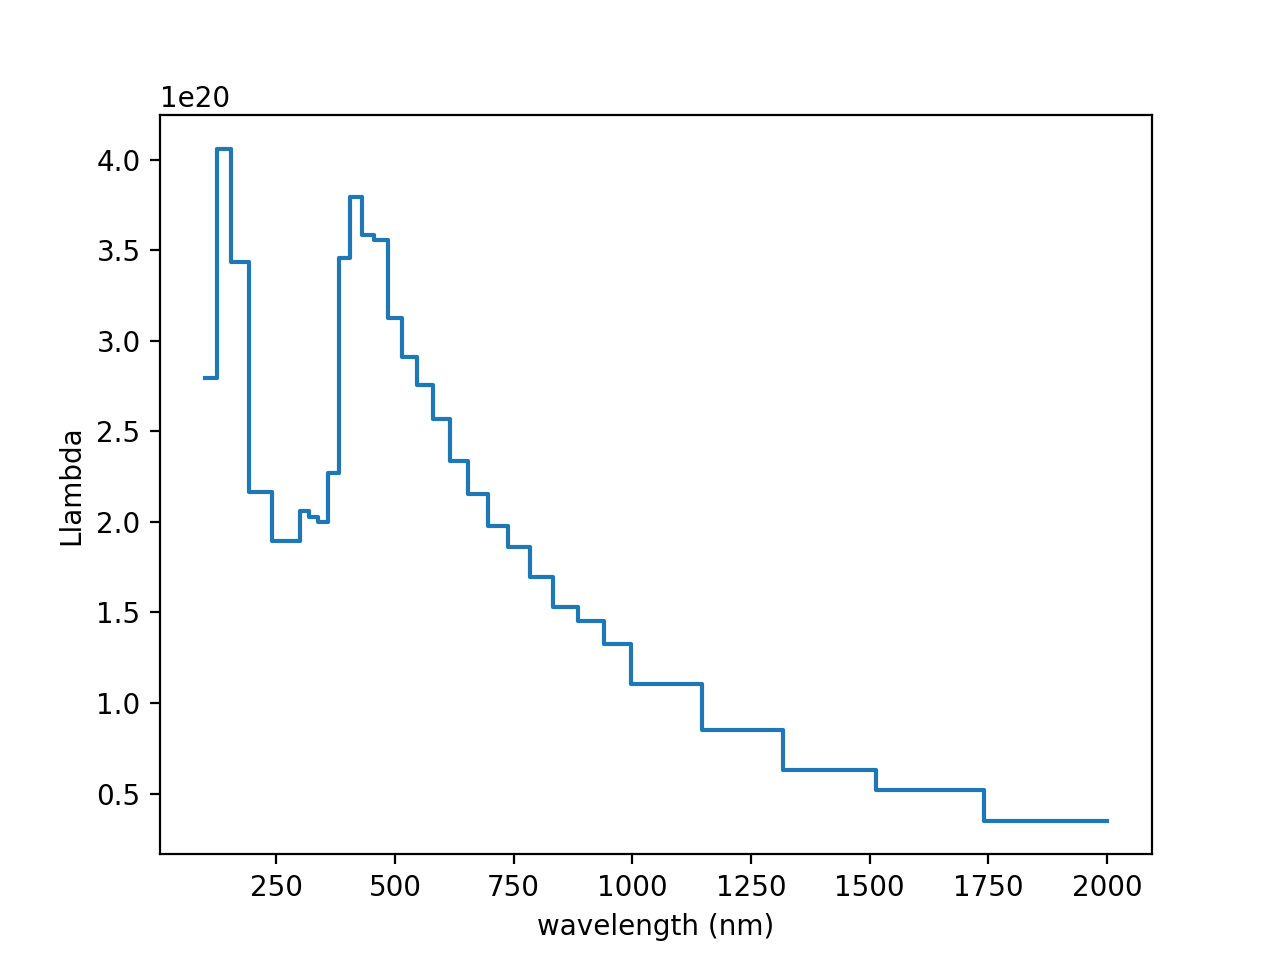

In [6]:
# cosmoDC2 really only considered the integrated luminosities in the 30 wavelength ranges.
# Dividing by the bin width in frequency to provide Lnu seems to have been done for "convenience".
#
# A more useful (and equally "valid") representation would be to convert the 30 tophat values to
# Llambda first.
clight = 3e8/1e-9  # speed of light in nm
nu0 = clight/wl0  # original bin edges in Hz
Llambda0 = Lnu0*(nu0[:-1] - nu0[1:])/(wl0[1:] - wl0[:-1])   # W/nm

Llambda = []
for i in range(len(Llambda0)):
    Llambda.extend((Llambda0[i], Llambda0[i]))

plt.figure()
plt.plot(wl, Llambda)
plt.xlabel('wavelength (nm)')
plt.ylabel('Llambda');

In [7]:
# Should we extrapolate to shorter wavelengths?  Light from star-forming regions is absorbed shortward of the
# Lyman limit at 91.2nm rest frame, so maybe we can just cut off the SED at 100nm?
class Flambda:
    def __init__(self, wl, Llambda):
        self.wl = np.array(wl)
        self.Llambda = np.array(Llambda)
        # Below 100 nm, try to extrapolate using a power-law in Flambda vs wl, using the centers of
        # the two lowest tophats to compute the parameters.
        wl_mid = (self.wl[1:] + self.wl[:-1])/2.
        self.a = (np.log(Llambda[2]) - np.log(Llambda[1]))/(np.log(wl_mid[1]) - np.log(wl_mid[0]))
        self.b = Llambda[0]/wl_mid[0]**self.a
    def __call__(self, wl_val):
        if wl_val < self.wl[0]:
            return self.b*wl_val**self.a
        return np.interp(wl_val, self.wl, self.Llambda)

<IPython.core.display.Javascript object>


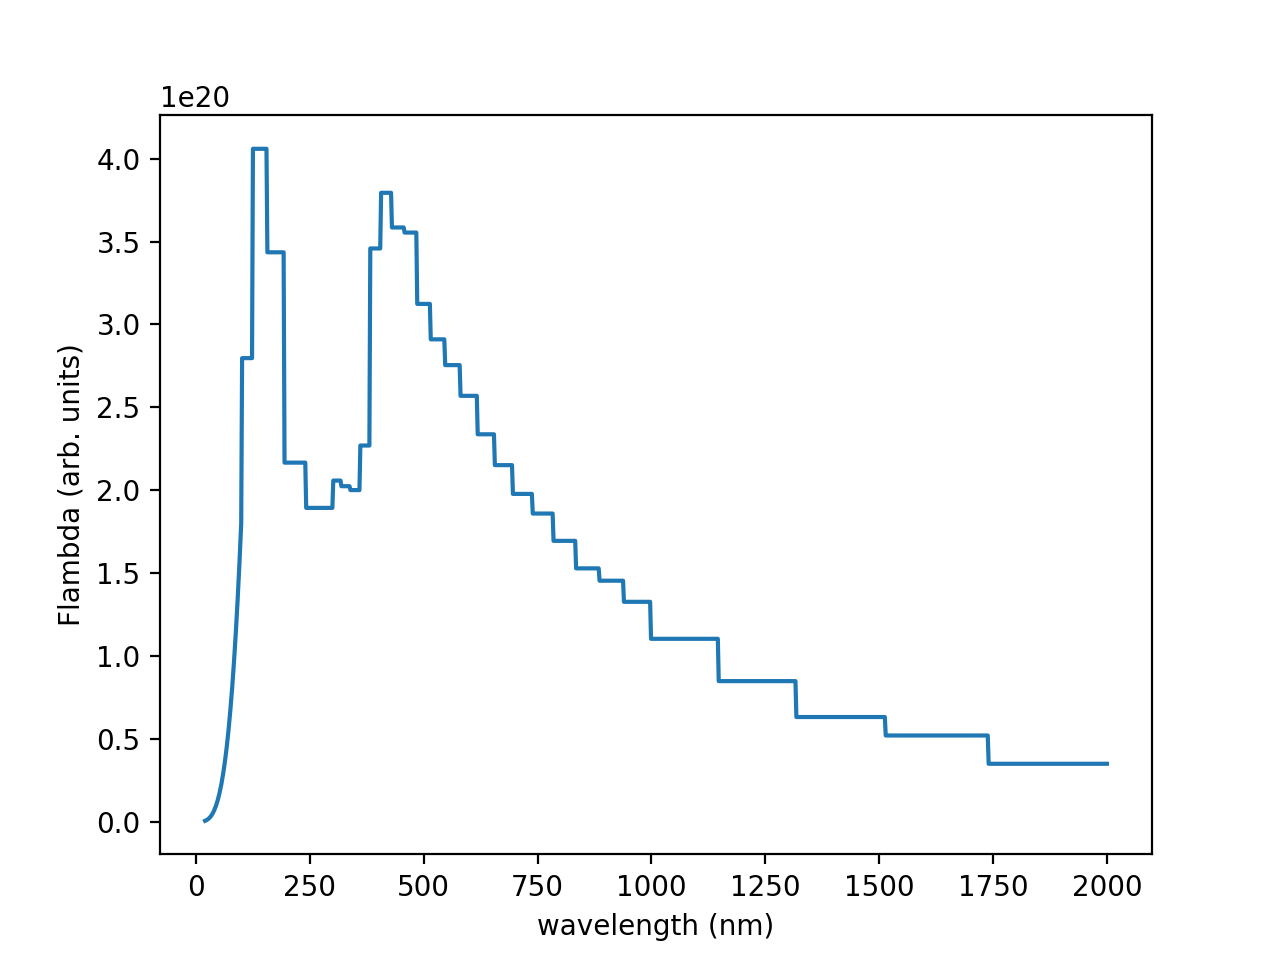

In [8]:
flambda = Flambda(wl, Llambda)

lam = np.linspace(20, 2000, 1000)
flam = [flambda(x) for x in lam]

plt.figure()
plt.plot(lam, flam)
plt.xlabel('wavelength (nm)')
plt.ylabel('Flambda (arb. units)');

In [9]:
# Try representing each tophat as a Gaussian function:
class GaussianSED:
    def __init__(self, wl0, Llambda0):
        self.mean = (wl0[1:] + wl0[:-1])/2.
        self.sigma = (wl0[1:] - wl0[:-1])/2.  # set sigma so that bin width corresponds to 1-sigma.
        self.norm = 0.68*Llambda0*(wl0[1:] - wl0[:-1])  # 1-sigma corresponds to 68% containment
    @staticmethod
    def _gaussian(x, mean, sigma):
        return np.exp(-(x - mean)**2/2./sigma**2)/np.sqrt(2.*np.pi*sigma**2)
    def __call__(self, wl):
        return sum(self._gaussian(wl, mean, sigma)*norm
                   for mean, sigma, norm in zip(self.mean, self.sigma, self.norm))

<IPython.core.display.Javascript object>


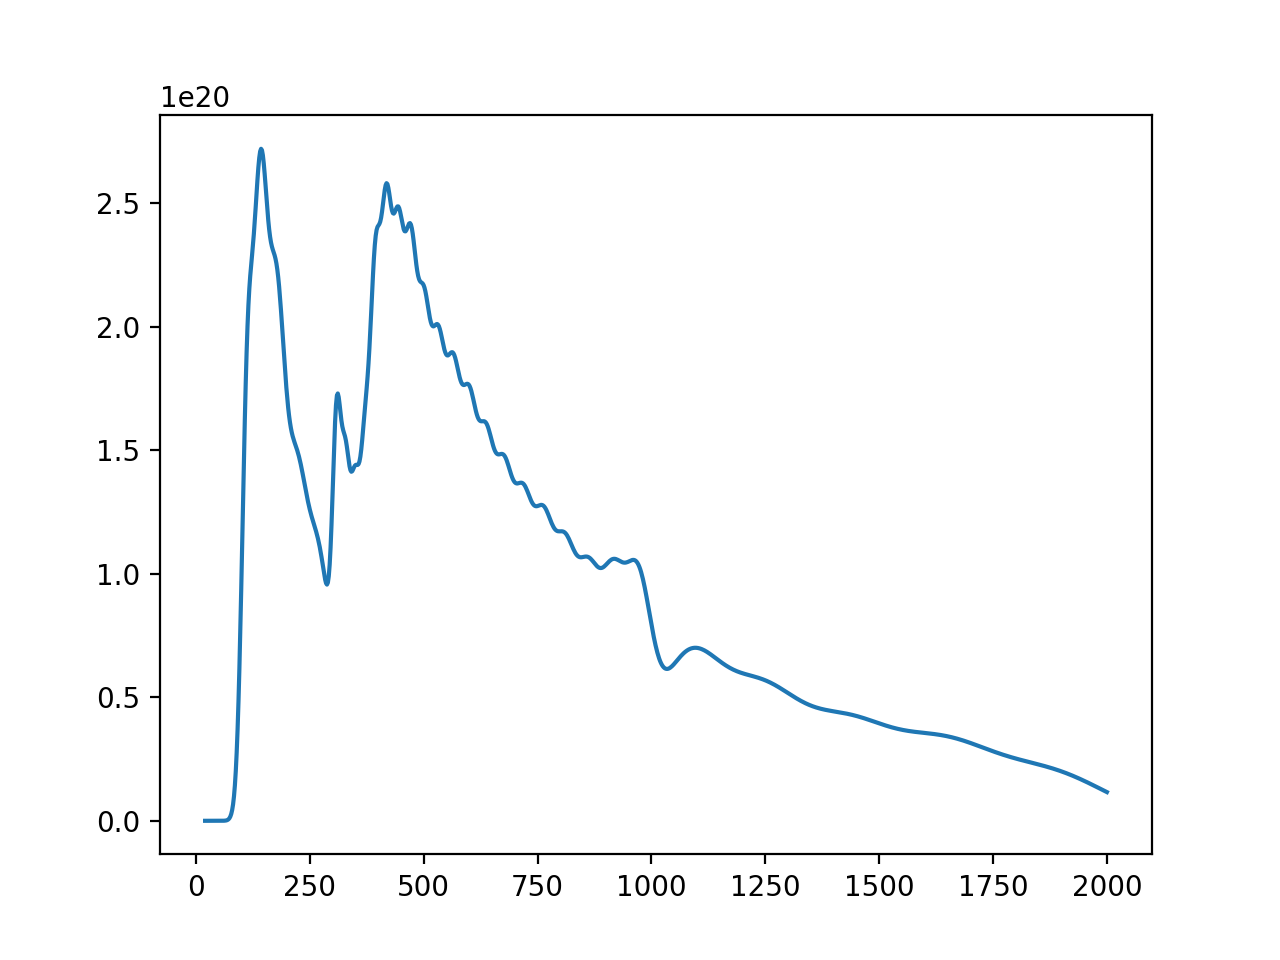

In [10]:
gauss_func = GaussianSED(wl0, Llambda0)
plt.figure()
plt.plot(lam, gauss_func(lam));

In [11]:
# If we use a galsim.LookupTable with the interpolant='nearest' option, we don't need to resample
# at higher resolution:
def sed_lookup_table(wl0, Lnu0, prepend_zero_bin=True, ref_wl=500.,
                     delta_wl=0.001):
    wl = np.array(wl0)
    # Convert tophat values from Lnu to Llambda.
    nu = 1./wl
    Llambda = np.array(Lnu0)*(nu[:-1] - nu[1:])/(wl[1:] - wl[:-1])

    # Create step functions for use with galsim.LookupTable.
    my_wl, my_Llambda = [], []
    # Even though the galsim.LookupTable class doesn't need a non-zero delta_wl to avoid repeated
    # abscissa values, the galsim.SED class does seem to need it.
    for i in range(len(Llambda)):
        my_wl.extend((wl[i], wl[i+1] - delta_wl))
        my_Llambda.extend((Llambda[i], Llambda[i]))
    if prepend_zero_bin:
        my_wl = [0, my_wl[0] - delta_wl] + my_wl
        my_Llambda = [0, 0] + my_Llambda
    lut = galsim.LookupTable(my_wl, my_Llambda, interpolant='nearest')
    # Normalize to unity at ref_wl.
    Lref = lut(ref_wl)
    return galsim.LookupTable(my_wl, np.array(my_Llambda)/Lref,
                              interpolant='nearest')

In [12]:
sed_lut = sed_lookup_table(wl0, Lnu0)
band = 'u'
throughput_file = os.path.join(os.environ['RUBIN_SIM_DATA_DIR'],
                               'throughputs', 'baseline', f'total_{band}.dat')
bp = galsim.Bandpass(throughput_file, wave_type='nm').thin()

<IPython.core.display.Javascript object>


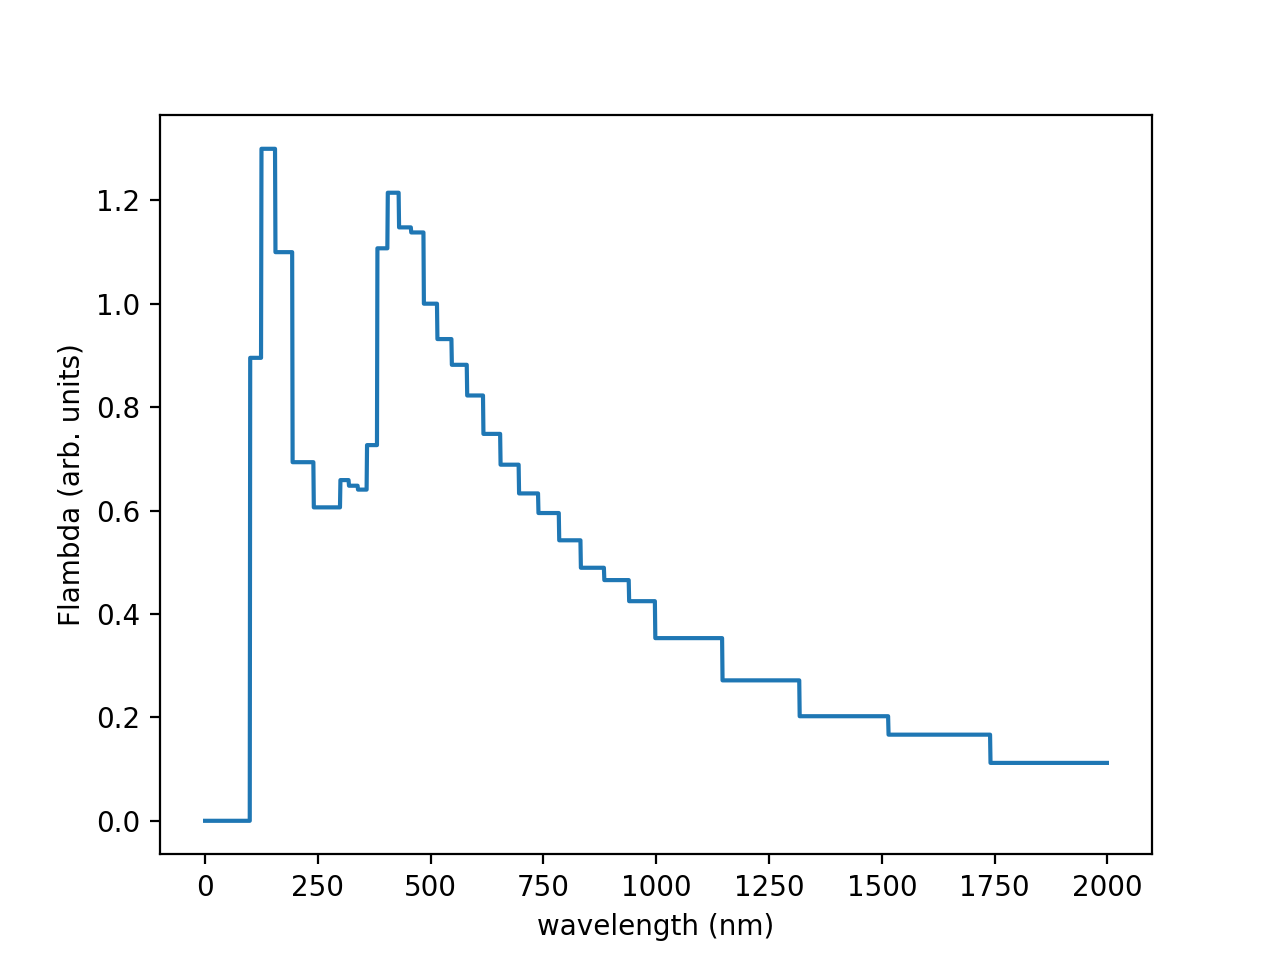

In [13]:
plt.figure()
wls = np.arange(0, max(wl0), 1)
flam = [sed_lut(_) for _ in wls]
plt.plot(wls, flam)
plt.xlabel('wavelength (nm)')
plt.ylabel('Flambda (arb. units)');

<IPython.core.display.Javascript object>


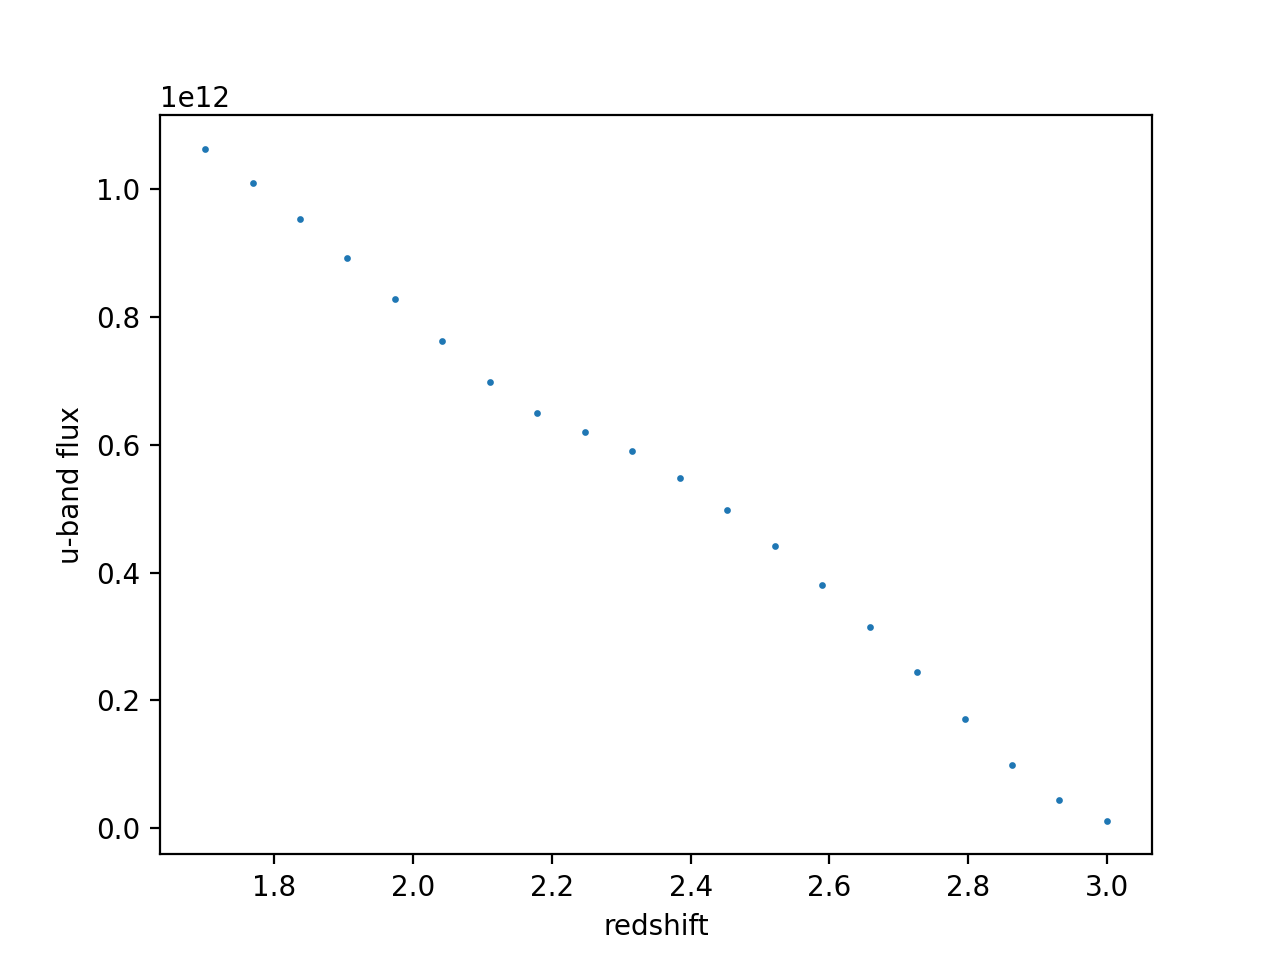

In [14]:
sed0 = galsim.SED(sed_lut, wave_type='nm', flux_type='flambda')
zvals = np.linspace(1.7, 3.0, 20)
fluxes = []
for z in zvals:
    sed = sed0.atRedshift(z)
    fluxes.append(sed.calculateFlux(bp))
plt.figure()
plt.scatter(zvals, fluxes, s=2)
plt.xlabel('redshift')
plt.ylabel(f'{band}-band flux');